## 0. Import relevant libraries

In [20]:
%matplotlib inline

import numpy as np
import pandas as pd
# import random as rd
# import pickle

import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d
# from scipy.interpolate import splrep, BSpline, CubicSpline, PchipInterpolator
# from scipy.signal import savgol_filter
# from scipy.ndimage import gaussian_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
# from csaps import csaps

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 1. Import features data

In [21]:
" Import data as Python pandas DataFrame "

_ADSORBATE_ = 'CH4'

LOC_STR = "data/zeolite/complete_data_avail.xlsx"
_DATA_ = pd.read_excel(LOC_STR, sheet_name=0, header=0, index_col='name')
            
_DATA = _DATA_[['density', 'spg', 'volume', 'pld', 'lcd', 'void_frac', 'surf_area_m2g',
       'surf_area_m2cm3', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere',
       'largest_included_sphere', 'largest_included_sphere_free']]


In [22]:
_DATA_

,Unnamed: 0,density,spg,volume,SiOSi_average,SiOSi_gmean,SiOSi_hmean,SiOSi_max,SiOSi_mean,SiOSi_min,...,largest_included_sphere,largest_included_sphere_free,max_dim,min_dim,mode_dim,pld,lcd,void_frac,surf_area_m2g,surf_area_m2cm3
name,,,,,,,,,,,,,,,,,,,,,
ABW,0,1.754532,74,18.955164,160.740416,160.343937,159.964020,180.000000,160.740416,149.408305,...,3.61163,3.61163,1,1,1,2.88024,3.60282,0.208281,0.0000,0.0000
ACO,1,1.642732,229,20.245206,156.295856,155.733278,155.207553,180.000000,156.295856,148.394474,...,3.91932,3.91754,3,3,3,2.93515,3.92937,0.307300,18.4268,30.2701
AEI,2,1.501576,63,22.148351,149.121203,149.110812,149.100401,151.266151,149.121203,146.100526,...,6.90319,6.90319,3,3,3,3.21360,6.69320,0.405097,613.2570,920.8470
AEL,3,1.914276,74,17.373380,151.484472,151.059147,150.650430,180.000000,151.484472,137.523964,...,5.22554,5.22554,1,1,1,3.98810,4.99656,0.188830,258.3630,494.5760
AEN,4,2.008222,64,16.560637,150.758467,150.162547,149.581048,180.000000,150.758467,128.216395,...,3.90726,3.90265,2,2,2,3.03180,3.79191,0.163004,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNI,190,1.752715,138,18.974810,146.468827,146.014494,145.564935,180.000000,146.468827,131.257522,...,4.40384,4.40384,2,1,1,2.52259,4.16864,0.190718,25.6035,44.8755
VSV,191,1.676330,141,19.839437,147.703048,147.000234,146.323234,180.000000,147.703048,131.043298,...,3.74729,3.73312,2,2,2,3.12184,3.68087,0.235589,0.0000,0.0000
WEI,192,1.646710,66,20.196299,135.652668,135.525332,135.400847,145.850467,135.652668,130.869665,...,3.79248,3.79248,3,3,3,2.81900,3.55872,0.269852,0.0000,0.0000


## 2. Import output variables' data

In [23]:
ADSORBATE_LOC_STR = "data/zeolite/"+ _ADSORBATE_ + ".xlsx"

ADSORBATE_xl = pd.ExcelFile(ADSORBATE_LOC_STR)
len(ADSORBATE_xl.sheet_names)  # sheet names


197

## 3. Obtain common adsorbents

In [24]:
_COMMON_ADSORBENTS = list(set(ADSORBATE_xl.sheet_names).intersection(_DATA.index))
print('There are ' + str(len(_COMMON_ADSORBENTS)) + ' common adsorbents.')


There are 190 common adsorbents.


### 3.1 Reindex based on common adsorbents

In [25]:
_DATA_REINDEXED = _DATA.reindex(_COMMON_ADSORBENTS)

print('Shape of the inputs is: ', _DATA_REINDEXED.shape)


Shape of the inputs is:  (190, 16)


In [26]:
_DATA_REINDEXED

,density,spg,volume,pld,lcd,void_frac,surf_area_m2g,surf_area_m2cm3,ASA,AV,NASA,NAV,VolFrac,largest_free_sphere,largest_included_sphere,largest_included_sphere_free
name,,,,,,,,,,,,,,,,
JST,1.427532,205,23.297156,3.11631,4.71507,0.382286,275.1090,392.7250,0.000,0.072377,441.4650,0.000000,0.10332,3.33236,4.94733,4.94733
AFT,1.502696,176,22.131853,3.05217,7.10440,0.400594,550.6920,900.9690,0.000,0.088162,655.9450,0.000000,0.13640,3.28060,7.13666,6.79037
IFR,1.711504,12,19.431711,5.74968,6.60655,0.351275,538.2560,921.2230,584.582,0.073421,0.0000,0.000000,0.12566,5.98202,6.56829,6.38944
MSO,1.778682,148,18.697801,1.46247,6.59499,0.263475,345.0730,646.4580,0.000,0.000000,393.3650,0.048958,0.00000,1.64391,6.82974,6.82974
UWY,1.626704,47,20.444678,5.46743,8.12474,0.353804,600.0020,976.0210,660.168,0.079695,0.0000,0.000000,0.12964,5.63563,8.37969,8.37969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RSN,1.676737,12,19.834621,3.12301,4.51178,0.250775,24.5691,41.1956,0.000,0.025323,24.3679,0.000000,0.04246,3.37038,4.26275,3.74508
MAZ,1.661452,176,20.017091,6.85021,7.43522,0.314787,307.8520,602.2760,282.378,0.061501,140.0200,0.000000,0.10218,7.10009,7.68968,7.55125
NES,1.640528,69,20.272396,4.44099,6.39655,0.331870,574.3680,942.2630,609.739,0.071441,0.0000,0.000000,0.11720,4.66101,6.17238,6.17238


## Load the data

Will only need to run this step in the future

In [27]:
with open('data/zeolite/CH4_TRAIN.npy', 'rb') as TRAIN_FILE:
    TRAIN_ADSORBENTS = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    
with open('data/zeolite/CH4_TEST.npy', 'rb') as TEST_FILE:
    TEST_ADSORBENTS = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    

## Evaluate Results – 323 K

In [28]:
with open('data/zeolite/CH4_RESULTS_323.npy', 'rb') as RESULTS_FILE:
    
    X_train = np.load(RESULTS_FILE, allow_pickle=True)
    X_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred = np.load(RESULTS_FILE, allow_pickle=True)
    y_train = np.load(RESULTS_FILE, allow_pickle=True)
    y_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_train = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_test = np.load(RESULTS_FILE, allow_pickle=True)
    P_TRAIN_STD = np.load(RESULTS_FILE, allow_pickle=True)


In [29]:
P_TRAIN_STD

array(1840178.90356372)

In [30]:
def predict_for_zeolite_323(_P_, normalized_features):
    
    P = _P_/P_TRAIN_STD
    
    density = normalized_features[0]; spg = normalized_features[1]; volume = normalized_features[2];
    pld = normalized_features[3]; lcd = normalized_features[4]; void_frac = normalized_features[5];
    surf_area_m2g = normalized_features[6]; surf_area_m2cm3 = normalized_features[7];
    ASA = normalized_features[8]; AV = normalized_features[9]; NASA = normalized_features[10];
    NAV = normalized_features[11]; VolFrac = normalized_features[12];
    largest_free_sphere = normalized_features[13]; largest_included_sphere = normalized_features[14]
    largest_included_sphere_free = normalized_features[15]
    print(f'{density=}')
    
    f1 = ((((largest_included_sphere)*np.exp(NAV)*np.exp(-surf_area_m2cm3)) * P / (1 + ((largest_included_sphere)*np.exp(NAV)*np.exp(-surf_area_m2cm3)) * P)) - 0.07469040214406462)/0.23351307544167757; beta1 = -0.4054507842872319
    f2 = (((1*np.exp(VolFrac)/np.exp(-AV)) * P / (1 + (1*np.exp(VolFrac)/np.exp(-AV)) * P)) - 0.593439038924528)/0.19855903035643785; beta2 = -3.5824569383000946
    f3 = (((1*np.exp(void_frac)/1) * P / (1 + (1*np.exp(void_frac)/1) * P)) - 0.6258918477237851)/0.19909573031440259; beta3 = 3.9932667095050705
    f4 = ((((AV)/np.exp(VolFrac)*(void_frac)) * P / (1 + ((AV)/np.exp(VolFrac)*(void_frac)) * P)) - 0.026347531768028034)/0.033050115887121194; beta4 = 0.5222507180877926
    f5 = (((np.exp(-NASA)*((surf_area_m2cm3)**2)*(spg)) * P / (1 + (np.exp(-NASA)*((surf_area_m2cm3)**2)*(spg)) * P)) - 0.451590663829706)/0.4976497103725683; beta5 = 0.004795464592376811
    f6 = (((((surf_area_m2cm3)**2)*np.exp(-volume)*(volume)) * P / (1 + (((surf_area_m2cm3)**2)*np.exp(-volume)*(volume)) * P)) - 0.04040880811128878)/0.05992104058313283; beta6 = -0.1129628499436825
    f7 = (((1/np.exp(surf_area_m2g)/(pld)) * P / (1 + (1/np.exp(surf_area_m2g)/(pld)) * P)) - 0.033471221601783376)/0.11285951143033723; beta7 = 0.013835556053187287
    f8 = (((((VolFrac)**2)/np.exp(-pld)/1) * P / (1 + (((VolFrac)**2)/np.exp(-pld)/1) * P)) - 0.3805783317820693)/0.36837799819503636; beta8 = -0.09608874134668977
    intercept = 0
    theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6 + beta7*f7 + beta8*f8
    loading_at_zero_P = -beta1*0.07469040214406462/0.233513075441677571 + -beta2*0.593439038924528/0.198559030356437852 + -beta3*0.6258918477237851/0.199095730314402593 + -beta4*0.026347531768028034/0.0330501158871211944 + -beta5*0.451590663829706/0.49764971037256835 + -beta6*0.04040880811128878/0.059921040583132836 + -beta7*0.033471221601783376/0.112859511430337237 + -beta8*0.3805783317820693/0.368377998195036368
    epsilon_max = 1
    d = np.abs(P - 0)
    alpha = 2
    yt = theta + intercept + np.mean(y_train) + np.abs(loading_at_zero_P + np.mean(y_train))* epsilon_max * np.exp(-alpha * d)
    
    return yt


# Specific Adsorbent

density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495


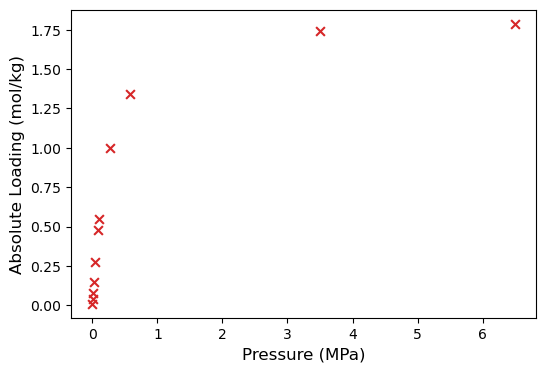

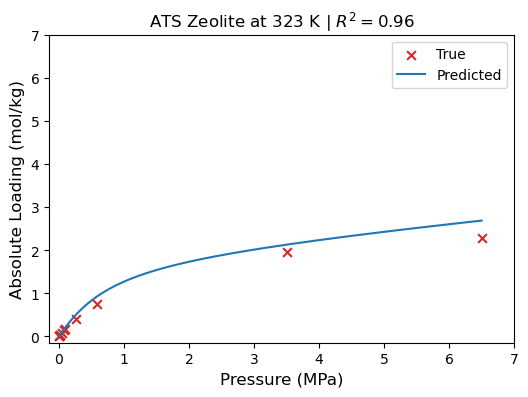

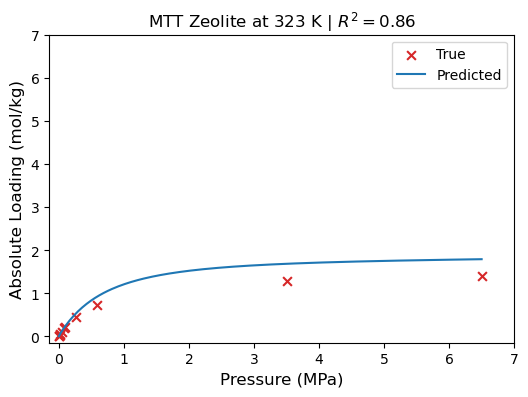

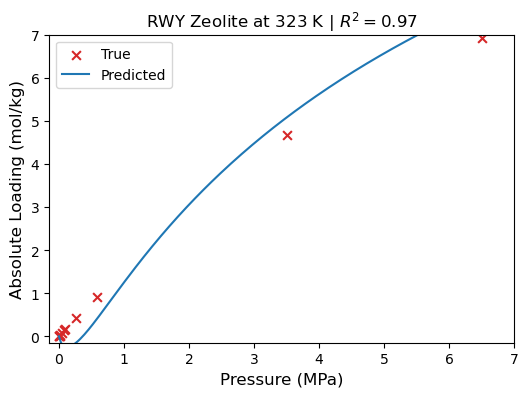

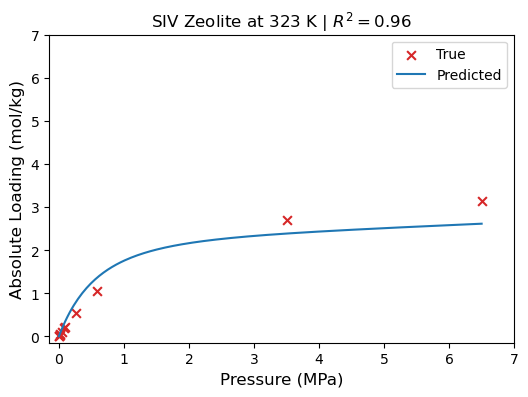

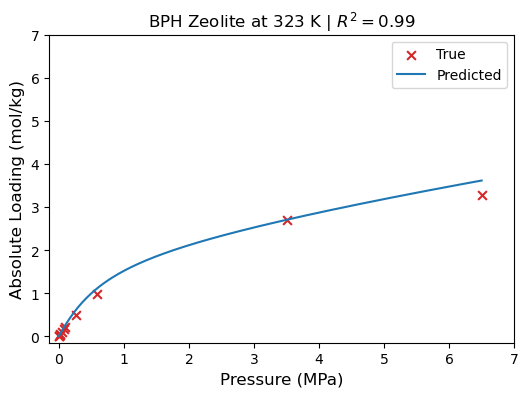

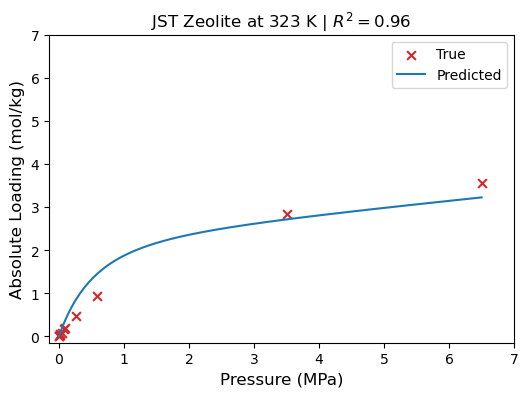

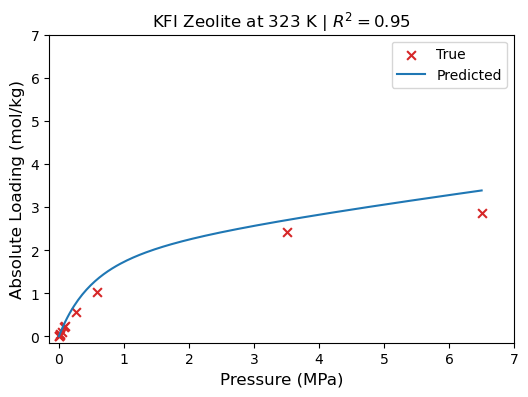

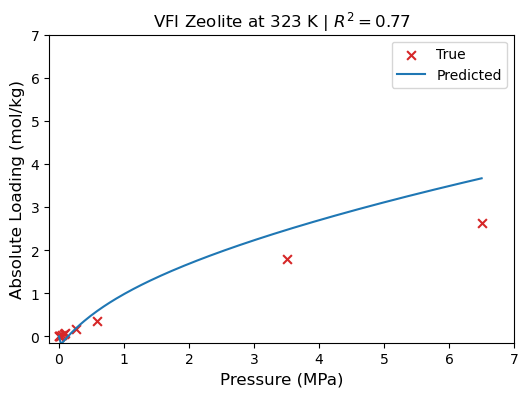

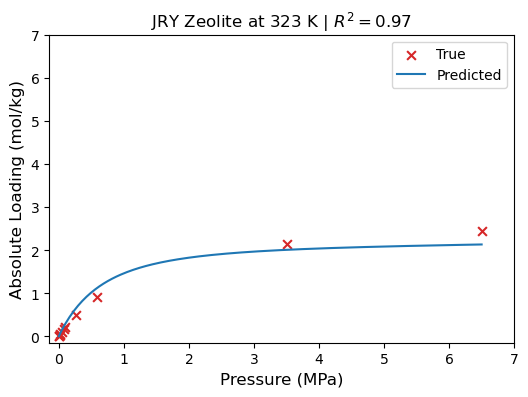

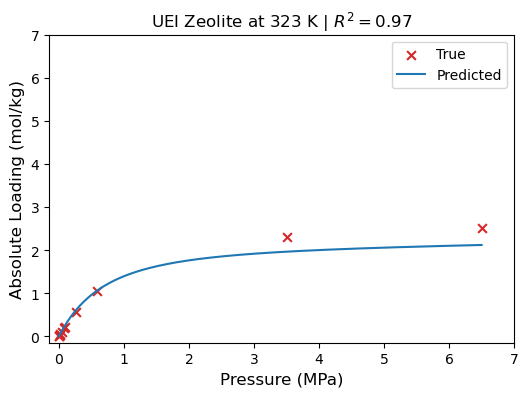

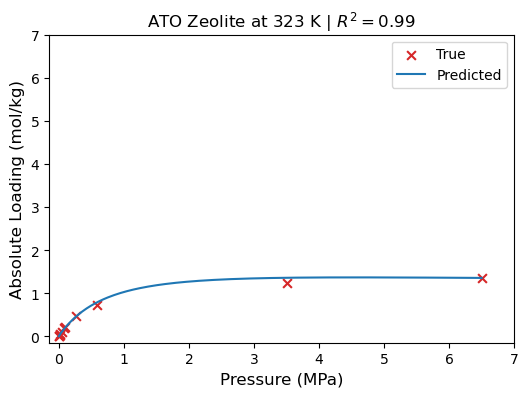

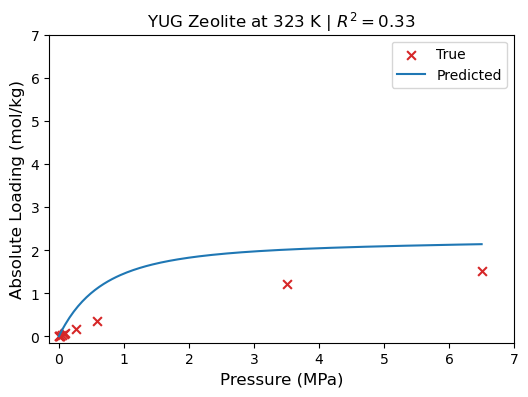

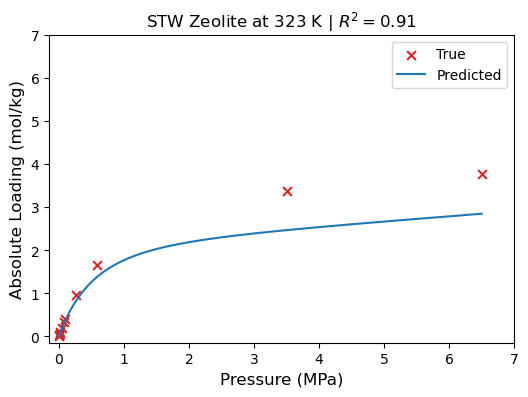

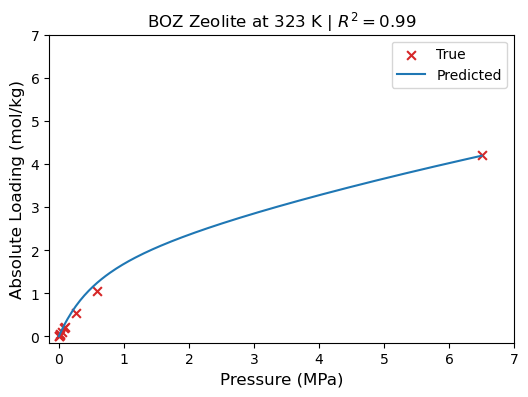

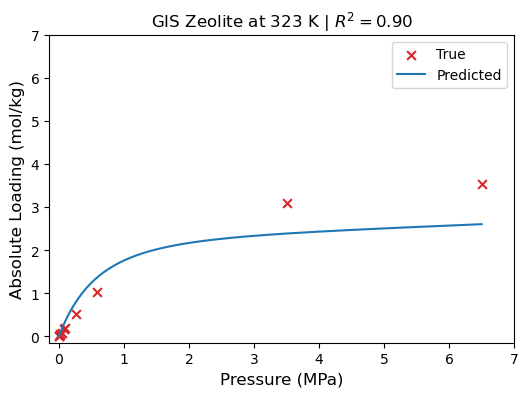

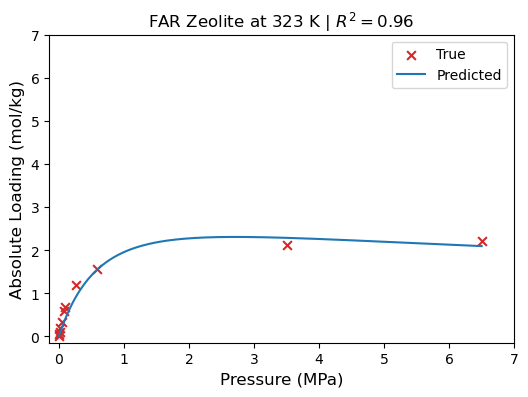

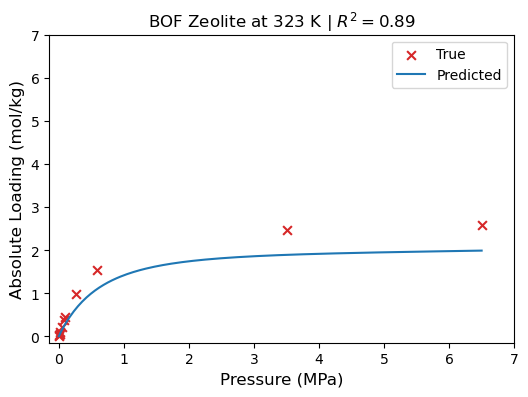

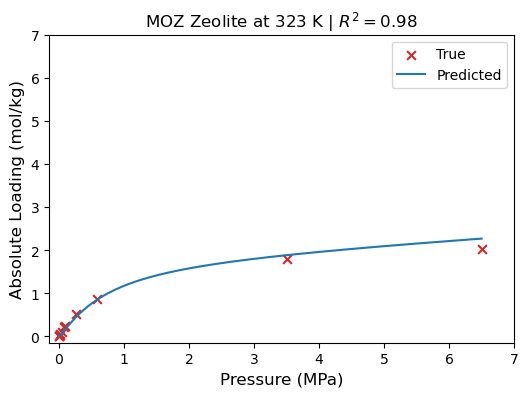

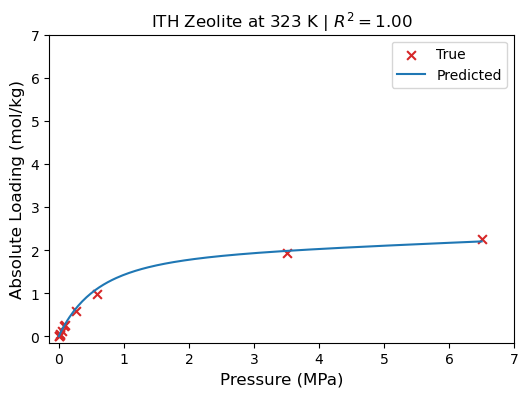

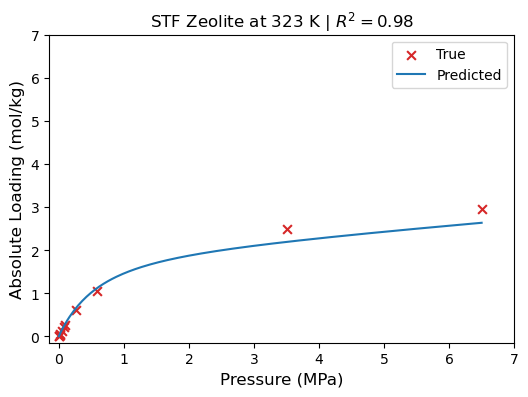

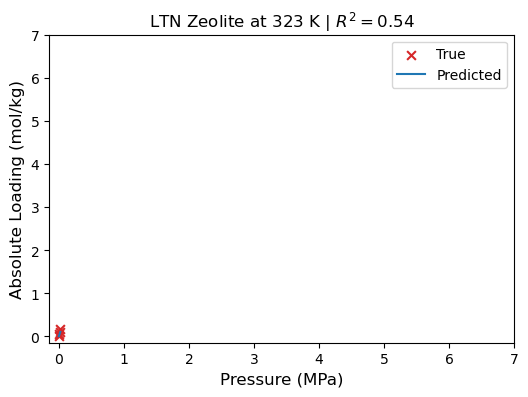

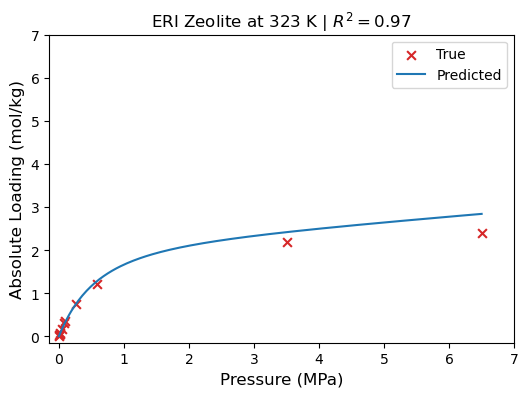

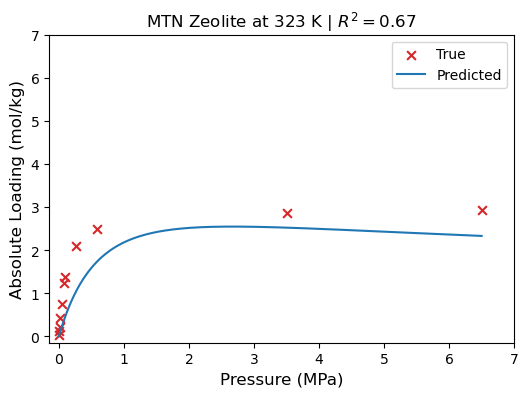

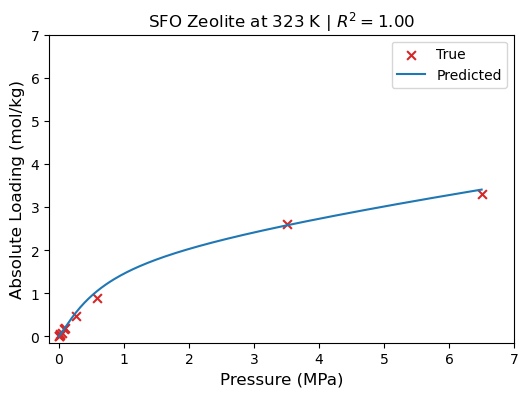

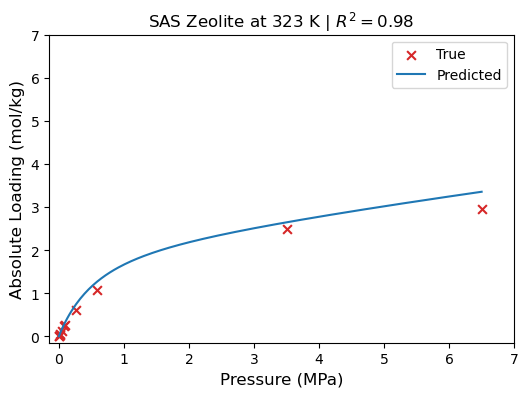

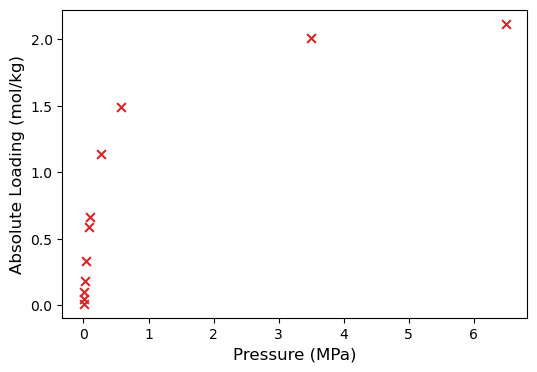

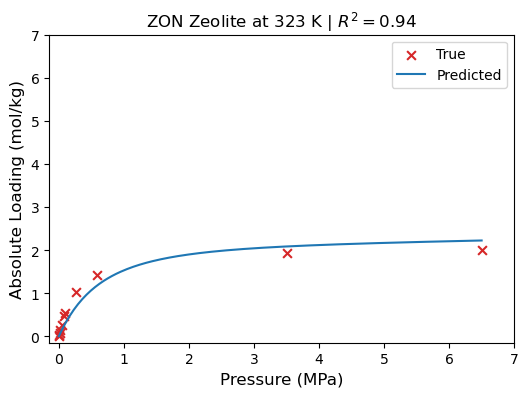

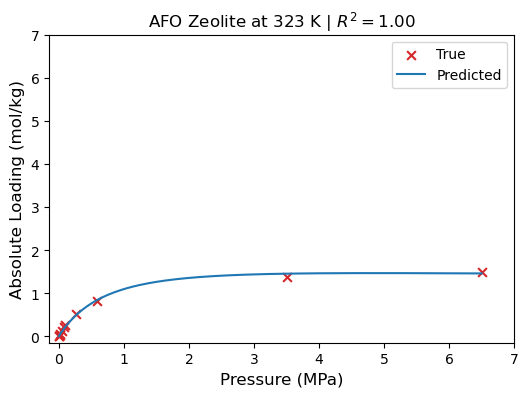

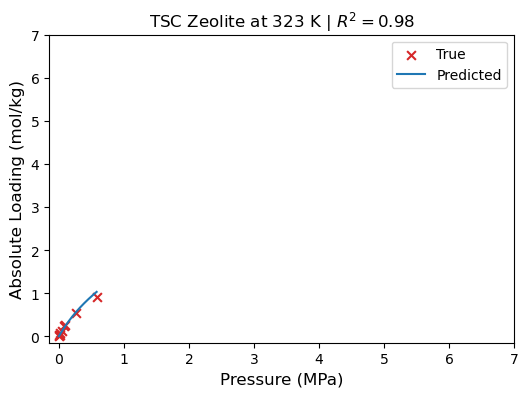

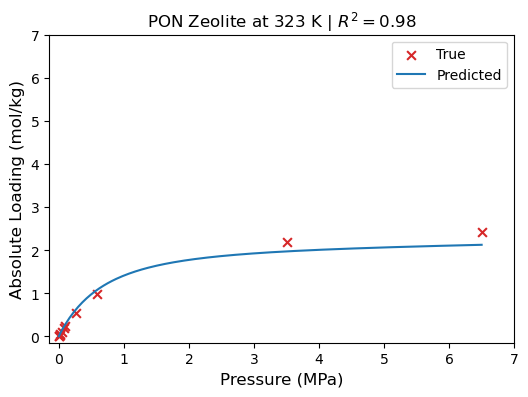

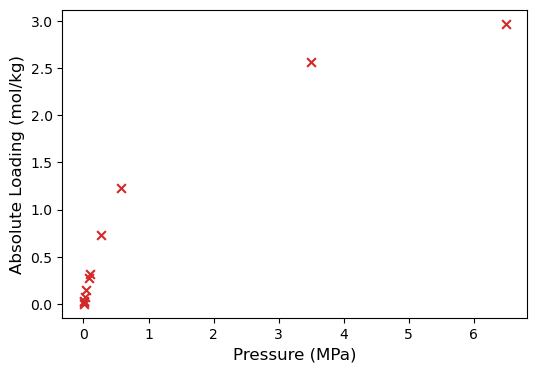

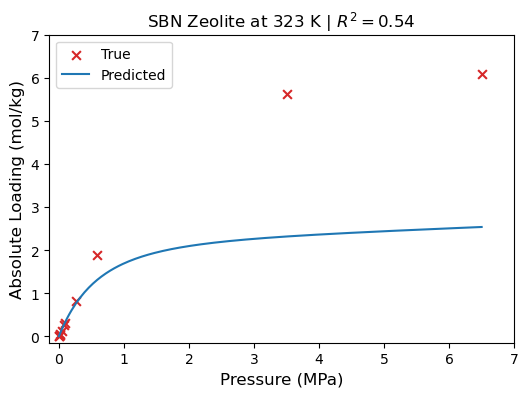

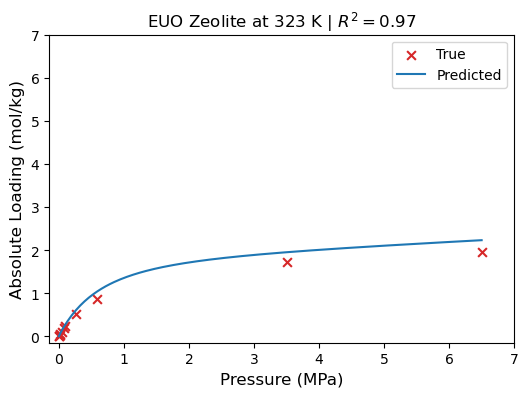

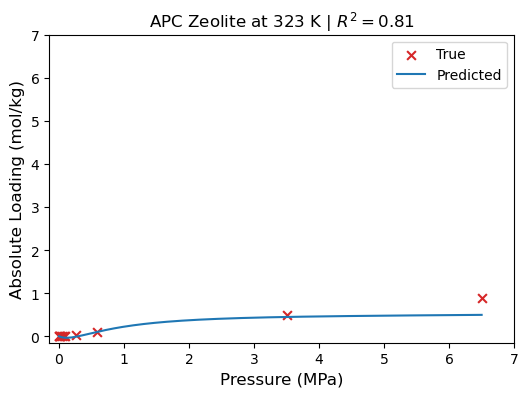

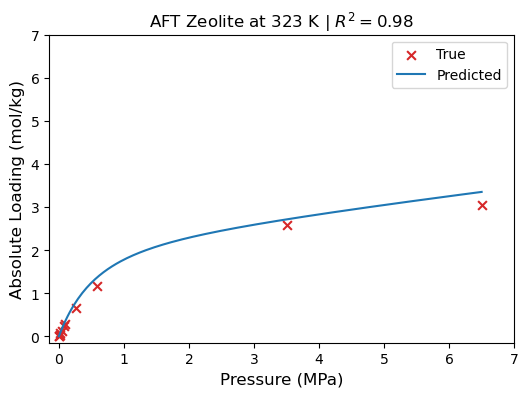

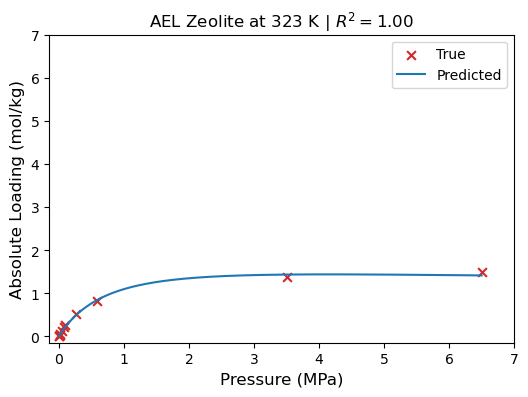

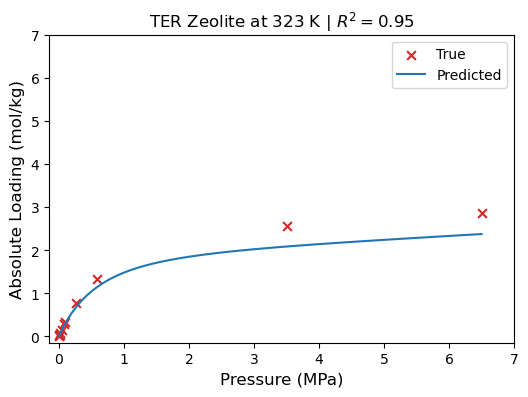

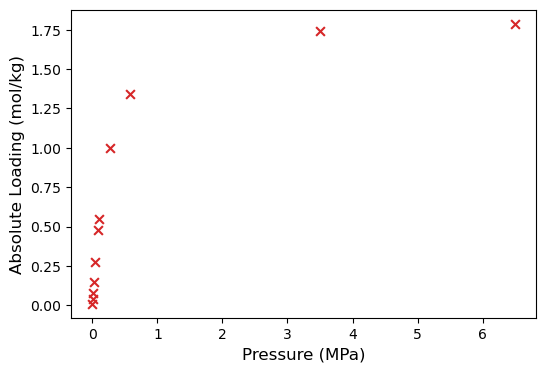

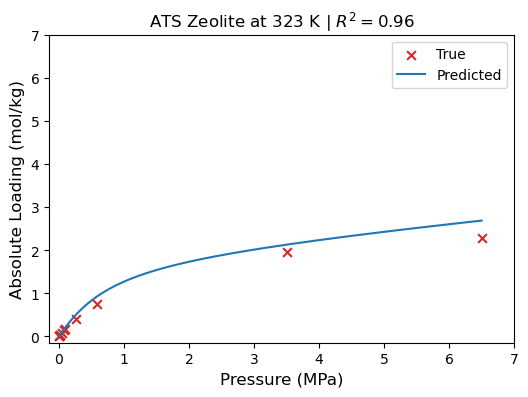

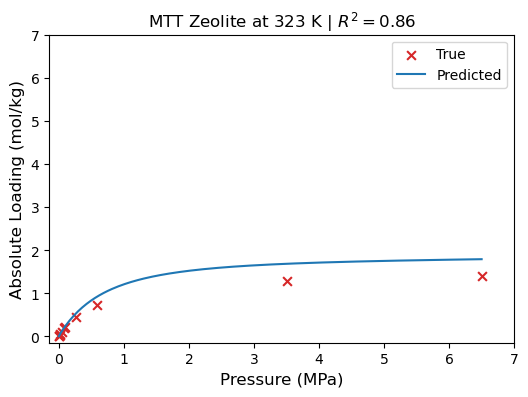

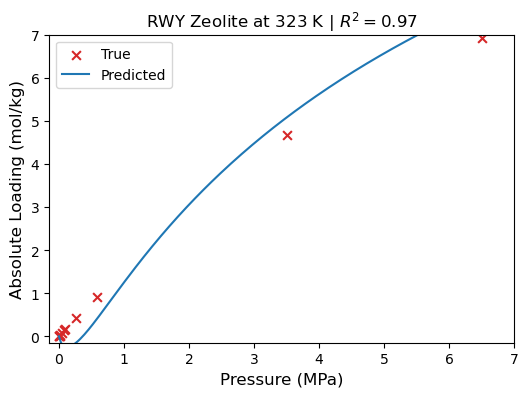

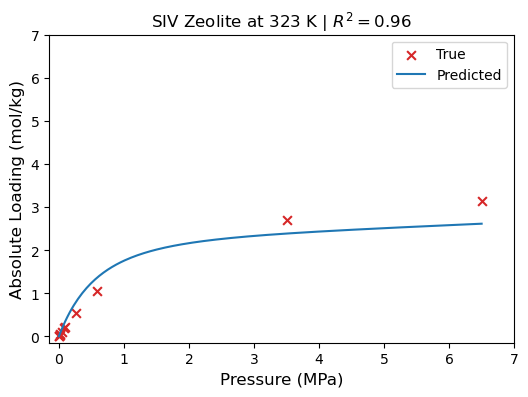

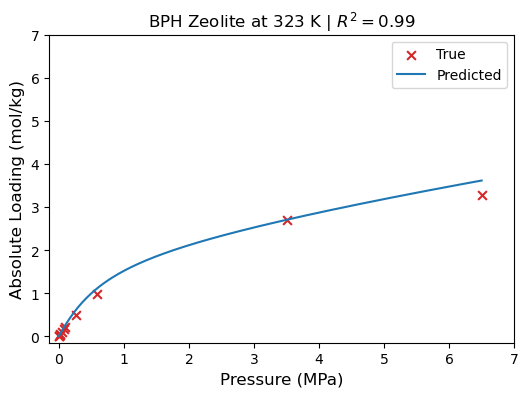

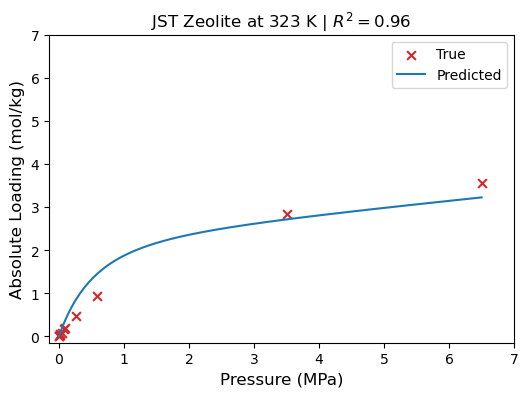

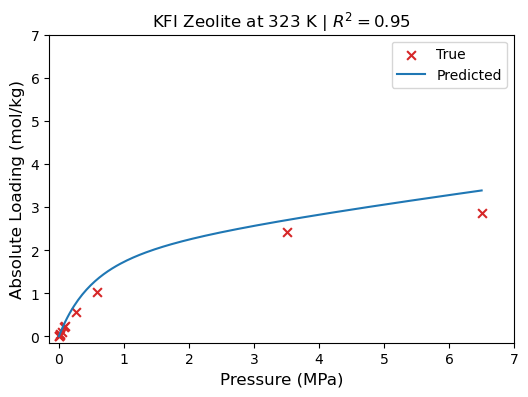

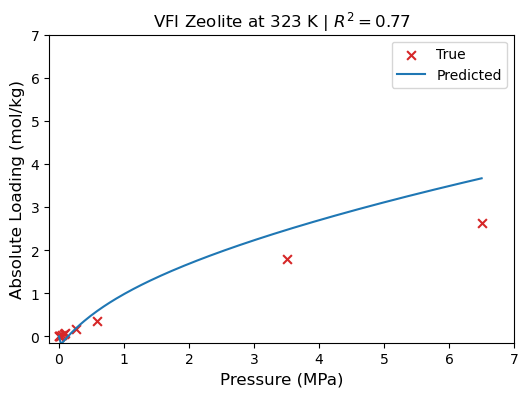

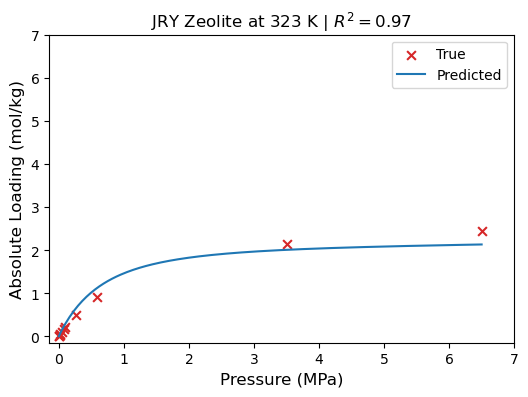

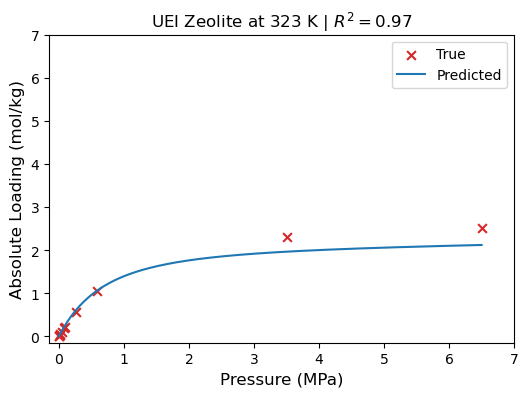

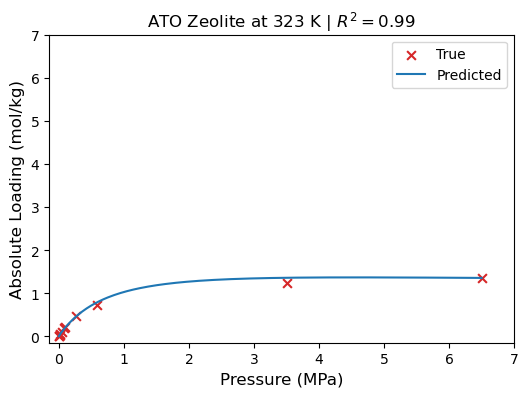

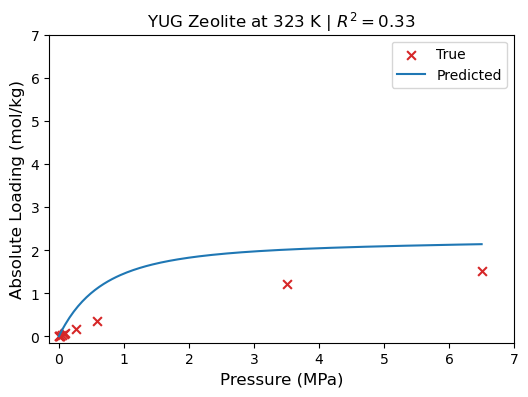

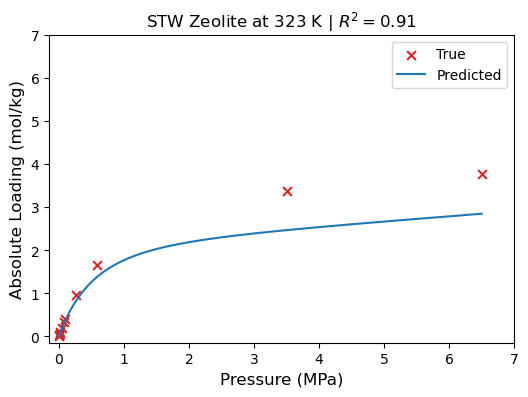

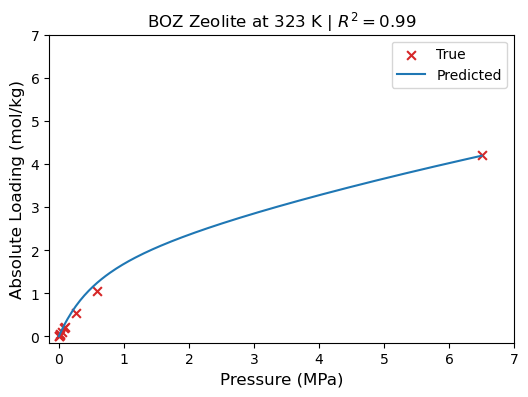

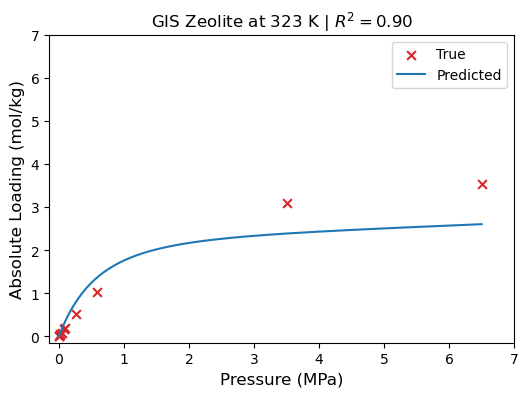

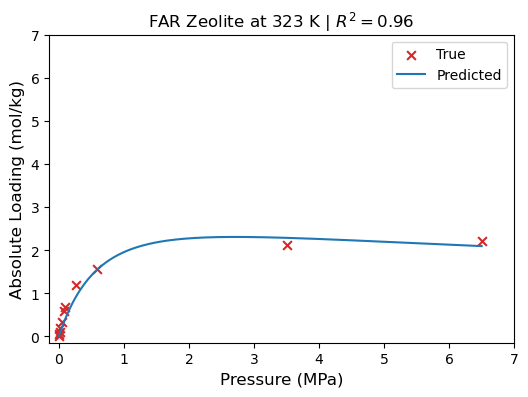

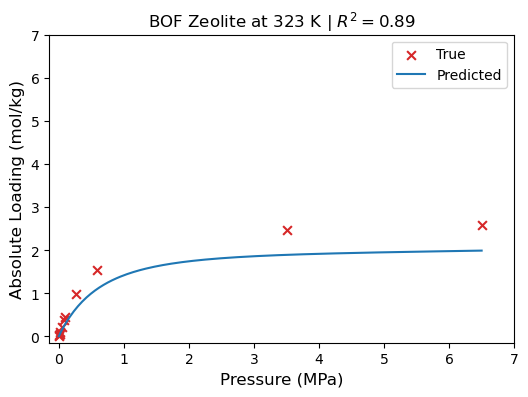

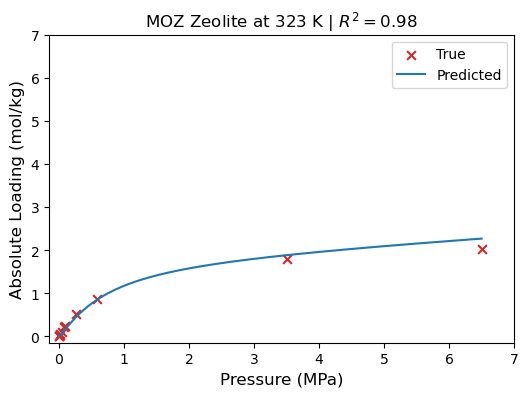

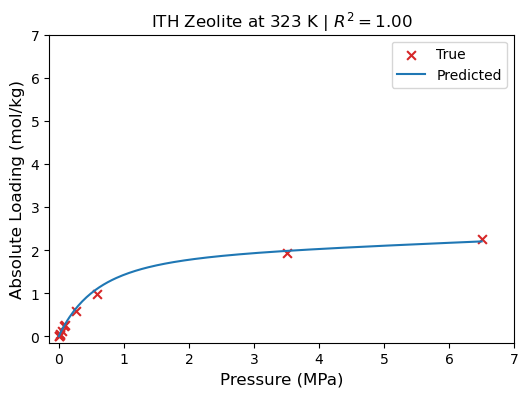

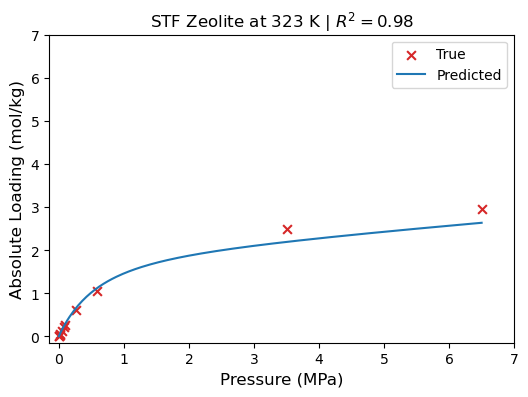

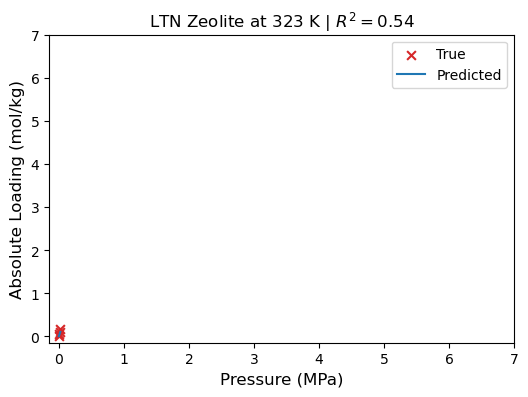

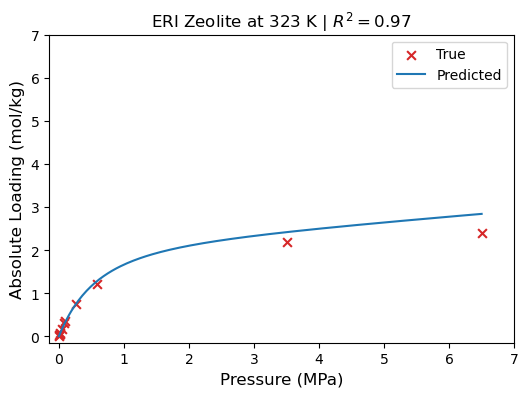

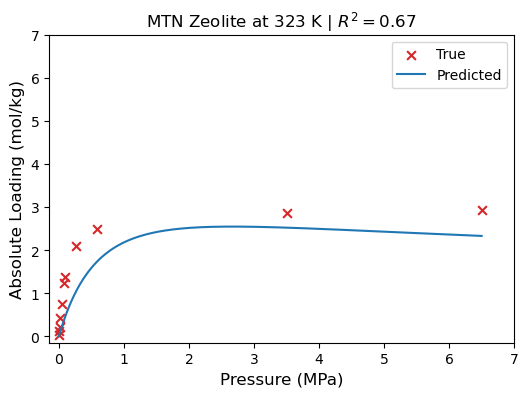

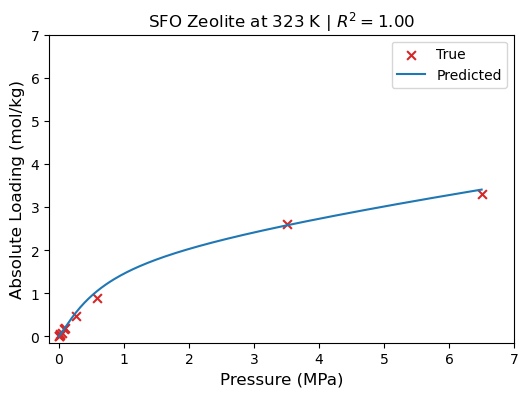

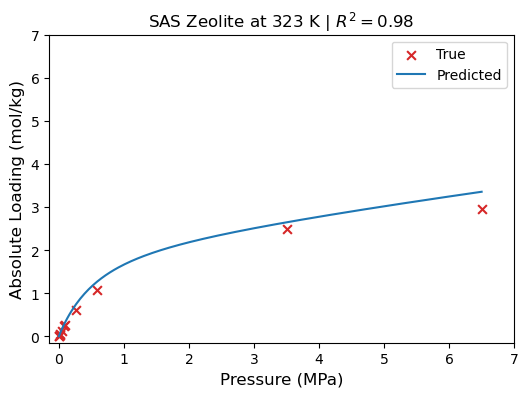

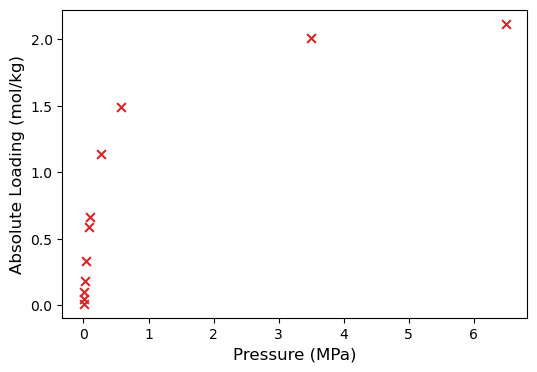

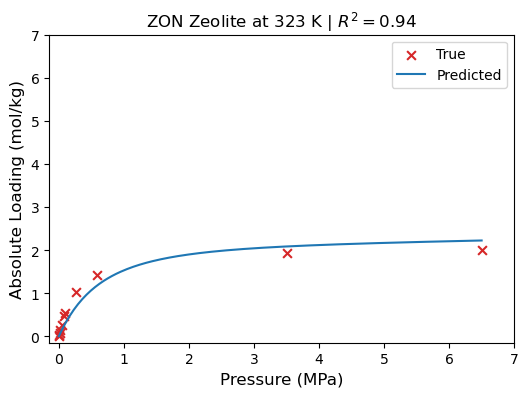

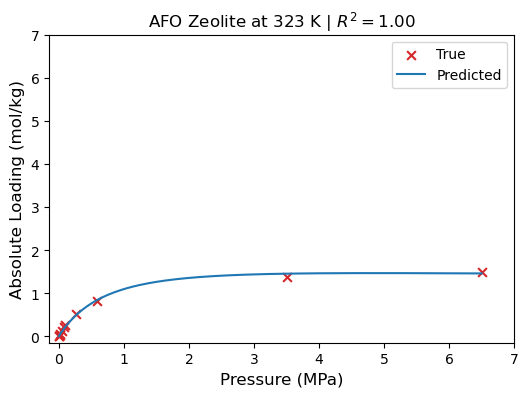

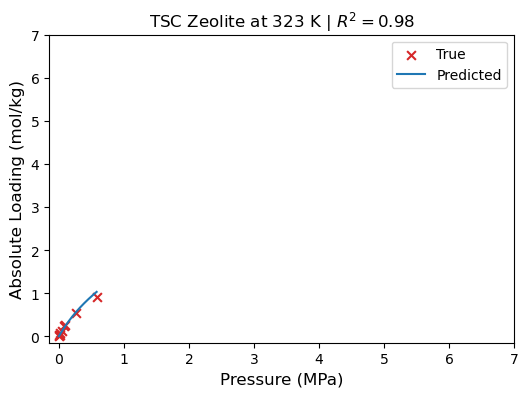

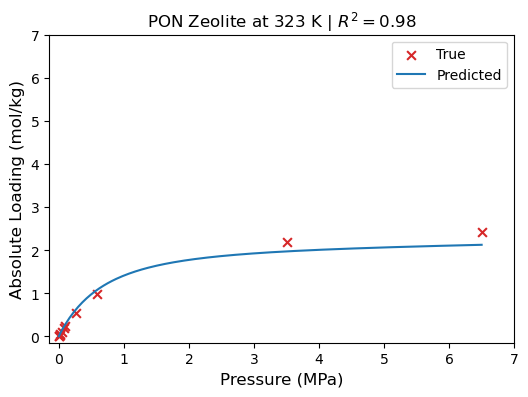

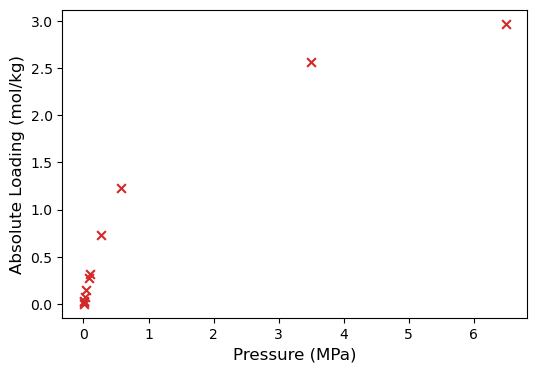

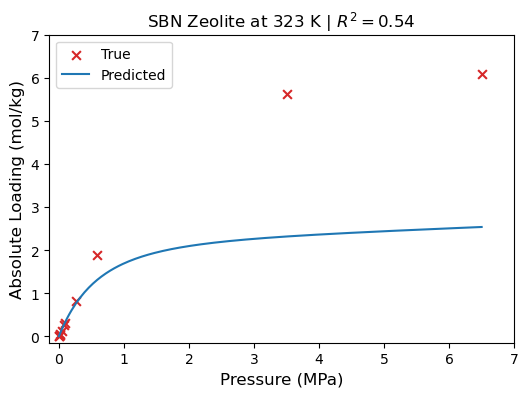

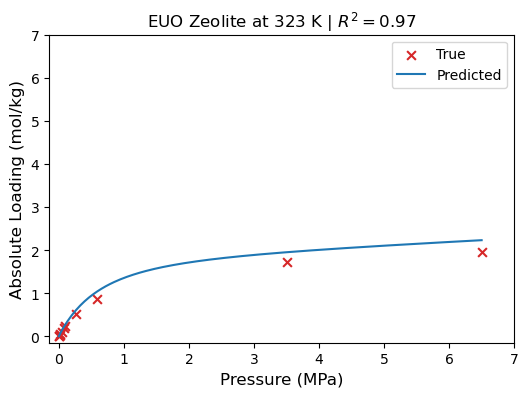

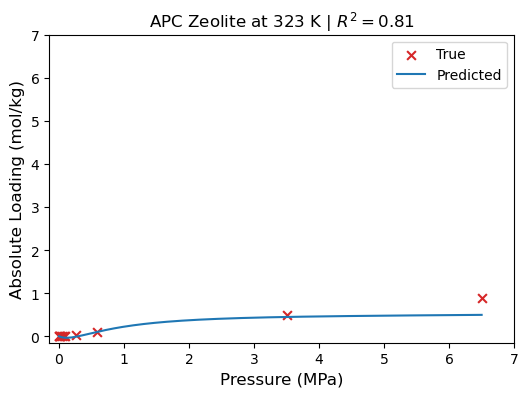

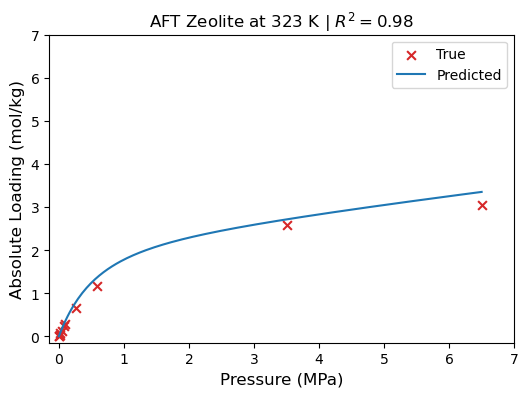

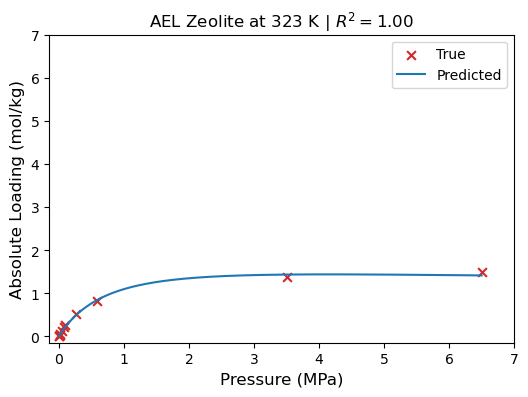

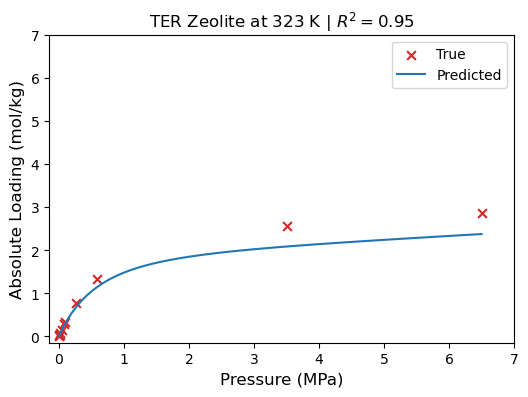

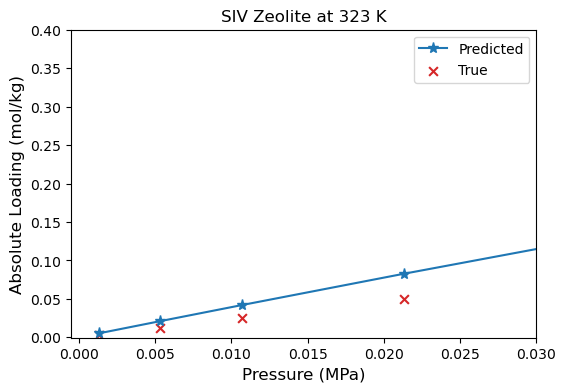

In [31]:
_specific_adsorbent_ = 'SIV'
plt.figure(figsize=(6,4), dpi=100)

CO2_OG_LOC_STR = r"data/zeolite/" + _ADSORBATE_ + ".xlsx"
CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_specific_adsorbent_)

_specific_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']])
predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_specific_adsorbent_])) for p in _specific_pressures_]

plt.plot(_specific_pressures_/1e6, predictions, label='Predicted', c='tab:blue', marker='*', markersize=8)

plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6,
           CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)'],
                   c='tab:red', label='True', marker='x', s=40)

plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
plt.xlabel('Pressure (MPa)', fontsize=12)

plt.title(r'{:s} Zeolite at 323 K'.format(_specific_adsorbent_))

plt.ylim(-0.0005, 0.4)
plt.xlim(-0.0005, 0.03)
plt.legend()
plt.show()


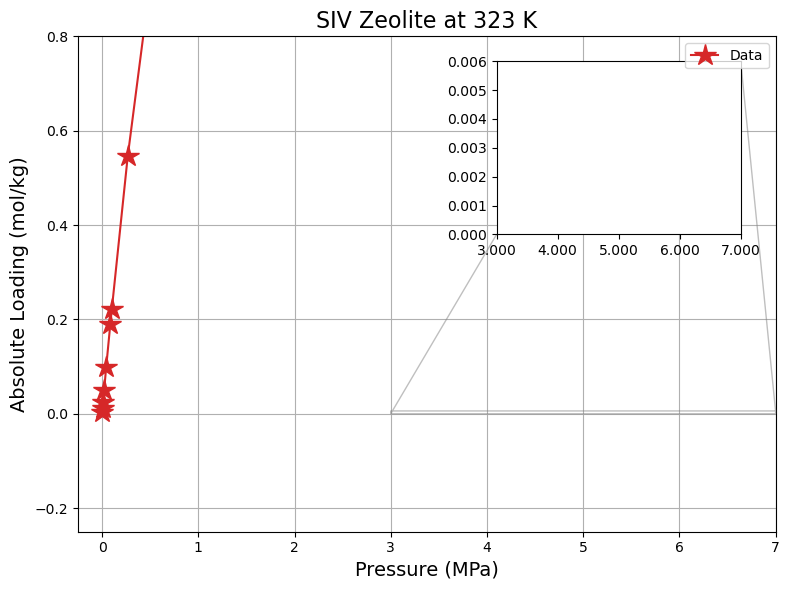

In [32]:
x = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6
y = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)']

# Assuming x and y are your numpy arrays
# Create main figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, label='Data', c='tab:red', marker='*', markersize=16)
ax.set_xlabel('Pressure (MPa)', fontsize=14)
ax.set_ylabel('Absolute Loading (mol/kg)', fontsize=14)
ax.set_title(r'{:s} Zeolite at 323 K'.format(_specific_adsorbent_), fontsize=16)
ax.set_xlim(-0.25, 7)  # Set main plot x range
ax.set_ylim(-0.25, 0.8)
ax.grid(True)

# Create inset axes
axins = ax.inset_axes([0.6, 0.6, 0.35, 0.35])

# Plot zoomed region
axins.plot(x, y, label='Data', c='tab:red', marker='*', markersize=12)
axins.set_xlim(3, 7)  # Zoom in to very small x range
# Get y values in the zoomed region
mask = (x >= 3.2) & (x <= 6.6)
y_zoom = y[mask]
axins.set_ylim(0,0.006)
# axins.set_ylim(min(y_zoom) - 0.1, max(y_zoom) + 0.1)
axins.grid(False)

# Add small tick marks for the zoomed region
axins.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Draw box showing zoom area
ax.indicate_inset_zoom(axins)

plt.legend()
plt.tight_layout()
plt.show()

In [34]:
TEST_ADSORBENTS

array(['RUT', 'ATS', 'MTT', 'RWY', 'SIV', 'BPH', 'JST', 'KFI', 'VFI',
       'JRY', 'UEI', 'ATO', 'YUG', 'STW', 'BOZ', 'GIS', 'FAR', 'BOF',
       'MOZ', 'ITH', 'STF', 'LTN', 'ERI', 'MTN', 'SFO', 'SAS', 'MAR',
       'ZON', 'AFO', 'TSC', 'PON', 'CHA', 'SBN', 'EUO', 'APC', 'AFT',
       'AEL', 'TER'], dtype='<U3')

In [33]:
_323_real_ = []
_323_pred_ = []

for _test_z_ in TEST_ADSORBENTS:
# for _test_z_ in TRAIN_ADSORBENTS:
    
    try:
        plt.figure(figsize=(6,4), dpi=100)

        CO2_OG_LOC_STR = r"data/zeolite/" + _ADSORBATE_ + ".xlsx"
        CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_test_z_)
        
        _specific_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                        'Temperature (K)']==323]['Pressure (Pa)']])
        _specific_predictions_ = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in _specific_pressures_]

        plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6,
                   CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)'],
                           c='tab:red', label='True', marker='x', s=40)

        min_p = min(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)'])
        max_p = max(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)'])
        p_range = np.linspace(0, max_p, 200)
        predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in p_range]

        plt.plot(p_range/1e6, predictions, label='Predicted', c='tab:blue')
        
        plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
        plt.xlabel('Pressure (MPa)', fontsize=12)
        
        plt.title(r'{:s} Zeolite at 323 K | $R^{:d}={:.2f}$'.format(_test_z_,2, r2_score(
                    CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323][
                        'Absolute Loading (mol/kg)'], [predict_for_zeolite_323(p, list(
                            _DATA_REINDEXED.loc[_test_z_])) for p in CO2_temp_adsorbent_data[
                                CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']])))
        
        _a_ = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]
        _323_pred_.append(_specific_predictions_)
        _323_real_.append(_a_['Absolute Loading (mol/kg)'].tolist())
    
        plt.ylim(-0.15,7)
        plt.xlim(-0.15, 7)
        plt.legend()
    except Exception as e:
        print(_test_z_, e)


density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.80889969368
density=1.

/var/folders/j9/zp971npn6lsbq6hczwf2rjtm0000gn/T/ipykernel_65845/3158521055.py:20: RuntimeWarning: overflow encountered in exp
  f7 = (((1/np.exp(surf_area_m2g)/(pld)) * P / (1 + (1/np.exp(surf_area_m2g)/(pld)) * P)) - 0.033471221601783376)/0.11285951143033723; beta7 = 0.013835556053187287


density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.63279417495
density=1.

/var/folders/j9/zp971npn6lsbq6hczwf2rjtm0000gn/T/ipykernel_65845/3158521055.py:20: RuntimeWarning: overflow encountered in exp
  f7 = (((1/np.exp(surf_area_m2g)/(pld)) * P / (1 + (1/np.exp(surf_area_m2g)/(pld)) * P)) - 0.033471221601783376)/0.11285951143033723; beta7 = 0.013835556053187287


density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.76999470555
density=1.

/var/folders/j9/zp971npn6lsbq6hczwf2rjtm0000gn/T/ipykernel_65845/1357442445.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,4), dpi=100)


density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.68370726865
density=1.

/var/folders/j9/zp971npn6lsbq6hczwf2rjtm0000gn/T/ipykernel_65845/3158521055.py:20: RuntimeWarning: overflow encountered in exp
  f7 = (((1/np.exp(surf_area_m2g)/(pld)) * P / (1 + (1/np.exp(surf_area_m2g)/(pld)) * P)) - 0.033471221601783376)/0.11285951143033723; beta7 = 0.013835556053187287


density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.81326456063
density=1.

In [14]:
def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

_preds = np.array(flatten_concatenation(_323_pred_))
_real = np.array(flatten_concatenation(_323_real_))

_323_preds = np.array(flatten_concatenation(_323_pred_))
_323_real = np.array(flatten_concatenation(_323_real_))

new_test_real = np.delete(_323_real, np.argwhere(np.isnan(_323_real)))
new_test_preds = np.delete(_323_preds, np.argwhere(np.isnan(_323_real)))
new_new_test_real = np.delete(new_test_real, np.argwhere(np.isnan(new_test_preds)))
new_new_test_preds = np.delete(new_test_preds, np.argwhere(np.isnan(new_test_preds)))

print(r2_score(new_new_test_real, new_new_test_preds))
print(mean_absolute_error(new_new_test_real, new_new_test_preds))


0.8926556270990593
0.14620123901148968
